# Data Pre-Processing

#### Import Packages and CSV

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.pandas.set_option("display.max_columns", None)
# Create Dataframe
df = pd.read_json(r"loan_approval_dataset.json")
# Print shape of dataset
print(df.shape)

(252000, 13)


## Data Cleaning

In [16]:
##these are the features with nan value
features_with_na=[features for features in df.columns if df[features].isnull().sum()>=1]
for feature in features_with_na:
    print(feature,np.round(df[feature].isnull().mean()*100,5), '% missing values')

In [17]:
features_with_na

[]

#### Check Null Values

* **There are no null values in the dataset**

**Handling Duplicates**

In [18]:
df.duplicated().sum()

0

* **No Duplicates in the dataset**

**Remove Id from the dataset as it cannot used in Model Training**

In [19]:
df.drop('Id', inplace=True, axis=1)

# Feature Engineering

### Split X and Y

* **Split Dataframe to X and y**
* **Here we set a variable X i.e, independent columns, and a variable y i.e, dependent column as the “Risk_Flag” column.**


In [20]:
df["Married/Single"]=df["Married/Single"].replace({'single':0,'married':1})
df["Car_Ownership"]=df["Car_Ownership"].replace({'no':0,'yes':1})

In [21]:
from sklearn.preprocessing import LabelEncoder

df["House_Ownership"]= LabelEncoder().fit_transform(df[["House_Ownership"]])
df["Profession"]= LabelEncoder().fit_transform(df[["Profession"]])
df["STATE"]= LabelEncoder().fit_transform(df[["STATE"]])
df["CITY"]= LabelEncoder().fit_transform(df[["CITY"]])

In [22]:
X = df.drop('Risk_Flag', axis=1)
y = df['Risk_Flag']

In [23]:
X.head()

,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS
0,1303834,23,3,0,2,0,33,251,13,3,13
1,7574516,40,10,0,2,0,43,227,14,9,13
2,3991815,66,4,1,2,0,47,8,12,4,10
3,6256451,41,2,0,2,1,43,54,17,2,12
4,5768871,47,11,0,2,0,11,296,22,3,14


# Classification

In [24]:
from imblearn.combine import SMOTETomek, SMOTEENN

# Resampling the minority class. The strategy can be changed as required.
smt = SMOTEENN(random_state=42,sampling_strategy='minority' )
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X, y)

## Train Test Split
- The train-test split procedure is used to estimate the performance of machine learning algorithms when they are used to make predictions on data not used to train the model.

- It is a fast and easy procedure to perform, the results of which allow you to compare the performance of machine learning algorithms.

In [25]:
from sklearn.model_selection import  train_test_split
# separate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((229306, 11), (57327, 11))

In [27]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, \
                            precision_score, recall_score, f1_score, roc_auc_score,roc_curve 
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [28]:
def evaluate_clf(true, predicted):
    acc = accuracy_score(true, predicted) # Calculate Accuracy
    f1 = f1_score(true, predicted) # Calculate F1-score
    precision = precision_score(true, predicted) # Calculate Precision
    recall = recall_score(true, predicted)  # Calculate Recall
    roc_auc = roc_auc_score(true, predicted) #Calculate Roc
    return acc, f1 , precision, recall, roc_auc

In [29]:
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
    "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(),
    "AdaBoost Classifier": AdaBoostClassifier(),
    "CatBoosting Classifier": CatBoostClassifier(verbose=False)
}

In [30]:
# Create a function which can evaluate models and return a report 
def evaluate_models(X, y, models):
    '''
    This function takes in X and y and models dictionary as input
    It splits the data into Train Test split
    Iterates through the given model dictionary and evaluates the metrics
    Returns: Dataframe which contains report of all models metrics with cost
    '''
    # separate dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    
    models_list = []
    accuracy_list = []
    auc= []
    
    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train) # Train model

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Training set performance
        model_train_accuracy, model_train_f1,model_train_precision,\
        model_train_recall,model_train_rocauc_score=evaluate_clf(y_train ,y_train_pred)


        # Test set performance
        model_test_accuracy,model_test_f1,model_test_precision,\
        model_test_recall,model_test_rocauc_score=evaluate_clf(y_test, y_test_pred)

        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])

        print('Model performance for Training set')
        print("- Accuracy: {:.4f}".format(model_train_accuracy))
        print('- F1 score: {:.4f}'.format(model_train_f1)) 
        print('- Precision: {:.4f}'.format(model_train_precision))
        print('- Recall: {:.4f}'.format(model_train_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))

        print('----------------------------------')

        print('Model performance for Test set')
        print('- Accuracy: {:.4f}'.format(model_test_accuracy))
        accuracy_list.append(model_test_accuracy)
        print('- F1 score: {:.4f}'.format(model_test_f1))
        print('- Precision: {:.4f}'.format(model_test_precision))
        print('- Recall: {:.4f}'.format(model_test_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))
        auc.append(model_test_rocauc_score)
        print('='*35)
        print('\n')
        
    report=pd.DataFrame(list(zip(models_list, accuracy_list)), columns=['Model Name', 'Accuracy']).sort_values(by=['Accuracy'], ascending=False)
        
    return report

## Model Training 

In [31]:
base_model_report =evaluate_models(X=X_res, y=y_res, models=models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9797
- F1 score: 0.9717
- Precision: 0.9682
- Recall: 0.9753
- Roc Auc Score: 0.9788


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9695
- F1 score: 0.9572
- Precision: 0.9597
- Recall: 0.9547
- Roc Auc Score: 0.9662


Gradient Boosting
Model performance for Training set
- Accuracy: 0.7561
- F1 score: 0.5862
- Precision: 0.7388
- Recall: 0.4859
- Roc Auc Score: 0.6955
----------------------------------
Model performance for Test set
- Accuracy: 0.7549
- F1 score: 0.5902
- Precision: 0.7326
- Recall: 0.4941
- Roc Auc Score: 0.6970


Logistic Regression
Model performance for Training 

**Results of All Models**

In [32]:
base_model_report

,Model Name,Accuracy
4,K-Neighbors Classifier,0.987249
0,Random Forest,0.979748
1,Decision Tree,0.969508
7,CatBoosting Classifier,0.964048
5,XGBClassifier,0.954001
2,Gradient Boosting,0.754950
6,AdaBoost Classifier,0.697158
3,Logistic Regression,0.642908


In [43]:
best_model = KNeighborsClassifier()
best_model = best_model.fit(X_train,y_train)
y_pred = best_model.predict(X_test)
score = accuracy_score(y_test,y_pred)
cr = classification_report(y_test,y_pred)

print("FINAL MODEL 'KNN'")
print ("Accuracy Score value: {:.4f}".format(score))
print (cr)

FINAL MODEL 'KNN'
Accuracy Score value: 0.9872
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     36856
           1       1.00      0.97      0.98     20471

    accuracy                           0.99     57327
   macro avg       0.99      0.98      0.99     57327
weighted avg       0.99      0.99      0.99     57327



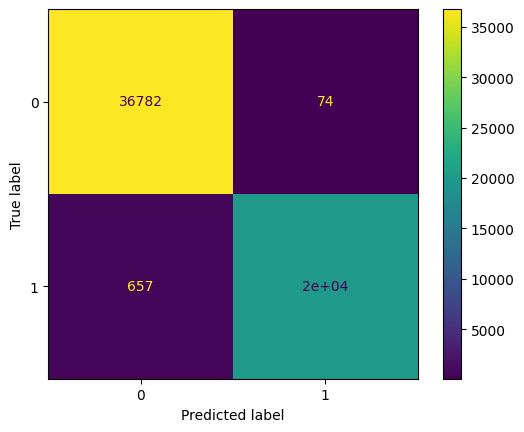

In [44]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)

## Best Model is K-Nearest Neighbor(KNN) with Accuracy 98.72%